In [1]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tabulate import tabulate

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [2]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

In [5]:
threshold = 0.55
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-11"
test_predictions_list, test_labels_list = [], []
train_predictions_list, train_labels_list = [], []

print(f"Identifier model date: {model_date}")
print(f"Threshold: {threshold}")

# Initialize lists to store results
results = []

for kmer in kmer_values:

    args.model_path = f"./outputs/identifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_test.txt"
    args.train_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_train.txt"

    # Load training and testing datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training dataset
    train_predictions, train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    train_predictions_list.append(train_predictions)
    train_labels_list.append(train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(train_predictions, train_labels)
    results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    test_predictions, test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    test_predictions_list.append(test_predictions)
    test_labels_list.append(test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(test_predictions, test_labels)
    results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

Identifier model date: 2025-02-11
Threshold: 0.55


In [6]:
# Convert results to DataFrame for tabulation
results_df = pd.DataFrame(results, columns=["k-mer", "Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Split DataFrame into training and testing
training_df = results_df[results_df['Dataset'].str.contains("Train")]
testing_df = results_df[results_df['Dataset'].str.contains("Test")]

# Display results in tabulated format
print("Training Results:")
print(tabulate(training_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

print("\nTesting Results:")
print(tabulate(testing_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))


Training Results:
+---------+-----------+------------+---------------+---------------+--------+--------+
|   k-mer | Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+=========+===========+============+===============+===============+========+========+
|       3 | Train     |     0.8999 |        0.8477 |        0.9522 | 0.8043 | 0.9015 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       4 | Train     |     0.9067 |        0.8504 |        0.9629 | 0.8185 | 0.9174 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       5 | Train     |     0.8848 |        0.8228 |        0.9468 | 0.7755 | 0.9083 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       6 | Train     |     0.8757 |        0.7978 |        0.9535 | 0.7606 | 0.8962 |
+---------+-----------+------------+---------------+---------------+--------+--------+

Testing Results:
+------

In [ ]:
# Calculate averages for training predictions and labels
train_predictions_average = np.array(train_predictions_list).mean(axis=0)
train_labels_average = np.array(train_labels_list).mean(axis=0)
train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_average, train_labels_average, threshold=threshold)

# Calculate averages for test predictions and labels
test_predictions_average = np.array(test_predictions_list).mean(axis=0)
test_labels_average = np.array(test_labels_list).mean(axis=0)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_average, test_labels_average, threshold=threshold)

# Prepare data for table
ensemble_results = [
    ["Ensemble Training", f"{train_acc:.4f}", f"{train_sn:.4f}", f"{train_sp:.4f}", f"{train_mcc:.4f}", f"{train_auc:.4f}"],
    ["Ensemble Testing", f"{test_acc:.4f}", f"{test_sn:.4f}", f"{test_sp:.4f}", f"{test_mcc:.4f}", f"{test_auc:.4f}"]
]
ensemble_results_df = pd.DataFrame(ensemble_results, columns=["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Display results 
print(f"Threshold = {threshold}")
print(tabulate(ensemble_results_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Threshold = 0.55
+-------------------+------------+---------------+---------------+--------+--------+
| Dataset           |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===================+============+===============+===============+========+========+
| Ensemble Training |     0.8999 |        0.8315 |        0.9683 | 0.8075 | 0.9316 |
+-------------------+------------+---------------+---------------+--------+--------+
| Ensemble Testing  |     0.8300 |        0.7600 |        0.9000 | 0.6666 | 0.8504 |
+-------------------+------------+---------------+---------------+--------+--------+


In [8]:
# Initialize the dictionary to store correct prediction indices
correct_predictions_dict = {}

# Iterate through kmer values and corresponding predictions and labels
for kmer, predictions, labels in zip(kmer_values, test_predictions_list, test_labels_list):
    # Convert predictions to binary labels
    binary_predictions = (np.array(predictions) > threshold).astype(int)
    
    # Compare binary predictions with true labels to determine correctness
    correct_indices = {index for index, (predicted, true) in enumerate(zip(binary_predictions.flatten(), labels)) if predicted == true}
    
    # Store the set of correct indices in the dictionary with kmer as string
    correct_predictions_dict[f"{kmer}-mer"] = correct_indices

print(correct_predictions_dict)

{'3-mer': {0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 144, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 177, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 

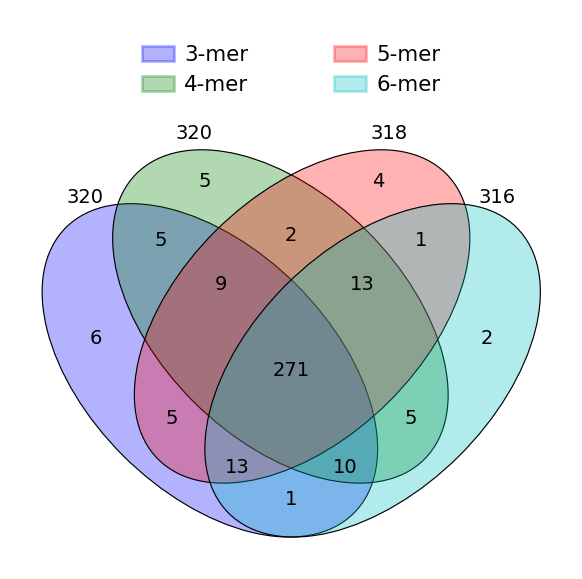

In [17]:
from venny4py.venny4py import *

venny4py(sets=correct_predictions_dict, out='analysis/venn/identifier')

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

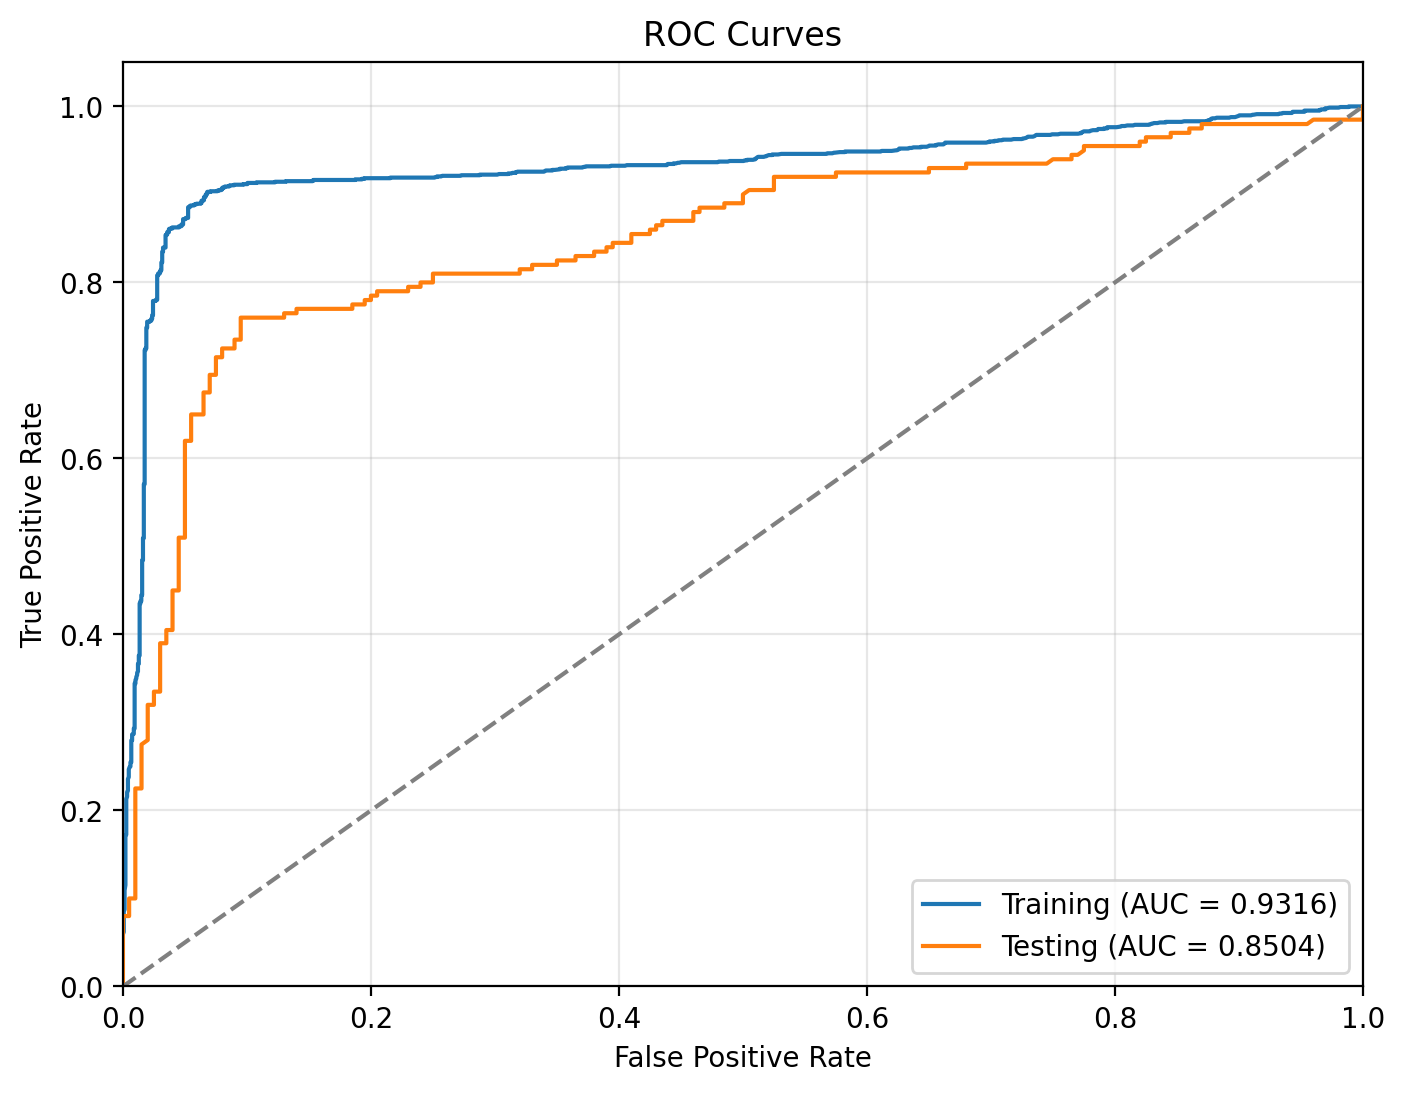

In [ ]:
# Function to plot ROC curve
def plot_single_roc_curve(predictions, labels, dataset_name):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{dataset_name} (AUC = {roc_auc:.4f})")


# Plot ROC curves for training and testing datasets
plt.figure(figsize=(8, 6))

# Training ROC Curve
plot_single_roc_curve(train_predictions_average, train_labels_average, "Training")

# Testing ROC Curve
plot_single_roc_curve(test_predictions_average, test_labels_average, "Testing")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

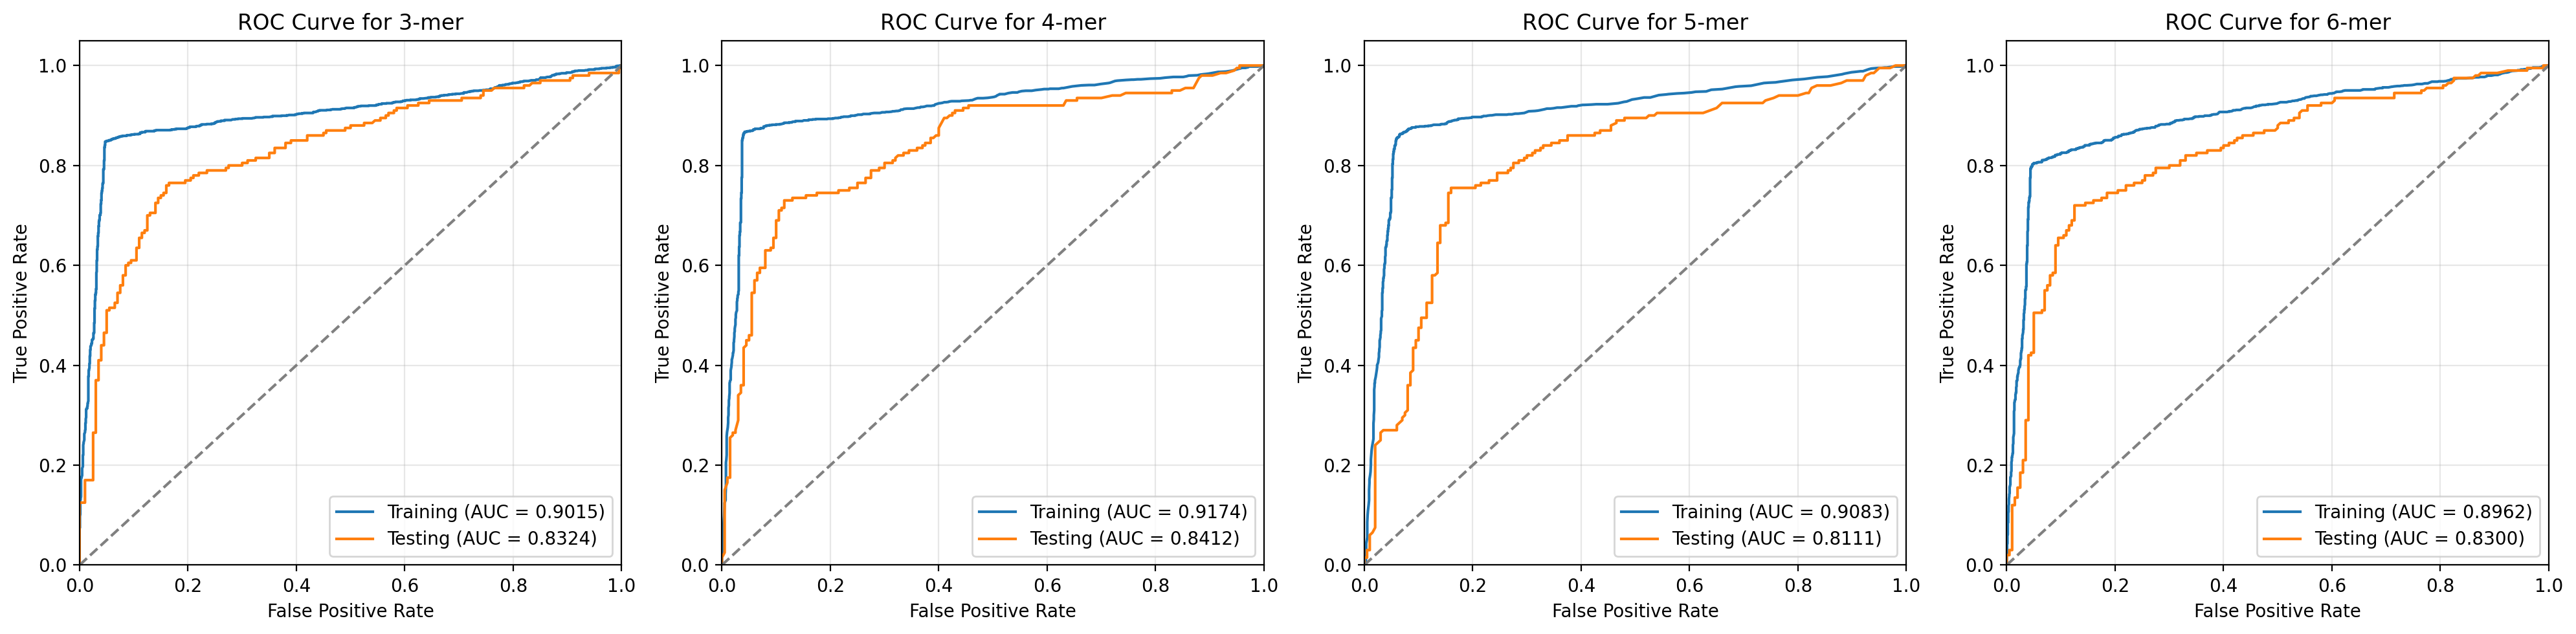

In [ ]:
def plot_roc_curve(ax, predictions_train, labels_train, predictions_test, labels_test, k):
    fpr_train, tpr_train, _ = roc_curve(labels_train, predictions_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, label=f"Training (AUC = {roc_auc_train:.4f})")

    fpr_test, tpr_test, _ = roc_curve(labels_test, predictions_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax.plot(fpr_test, tpr_test, label=f"Testing (AUC = {roc_auc_test:.4f})")

    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve for {k}-mer")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)


num_kkmer_values = len(kmer_values)
cols = 4
rows = (num_kkmer_values + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, mer in enumerate(kmer_values):
    train_predictions = train_predictions_list[i]
    train_labels = train_labels_list[i]
    test_predictions = test_predictions_list[i]
    test_labels = test_labels_list[i]

    plot_roc_curve(axes[i], train_predictions, train_labels, test_predictions, test_labels, mer)

for j in range(num_kkmer_values, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

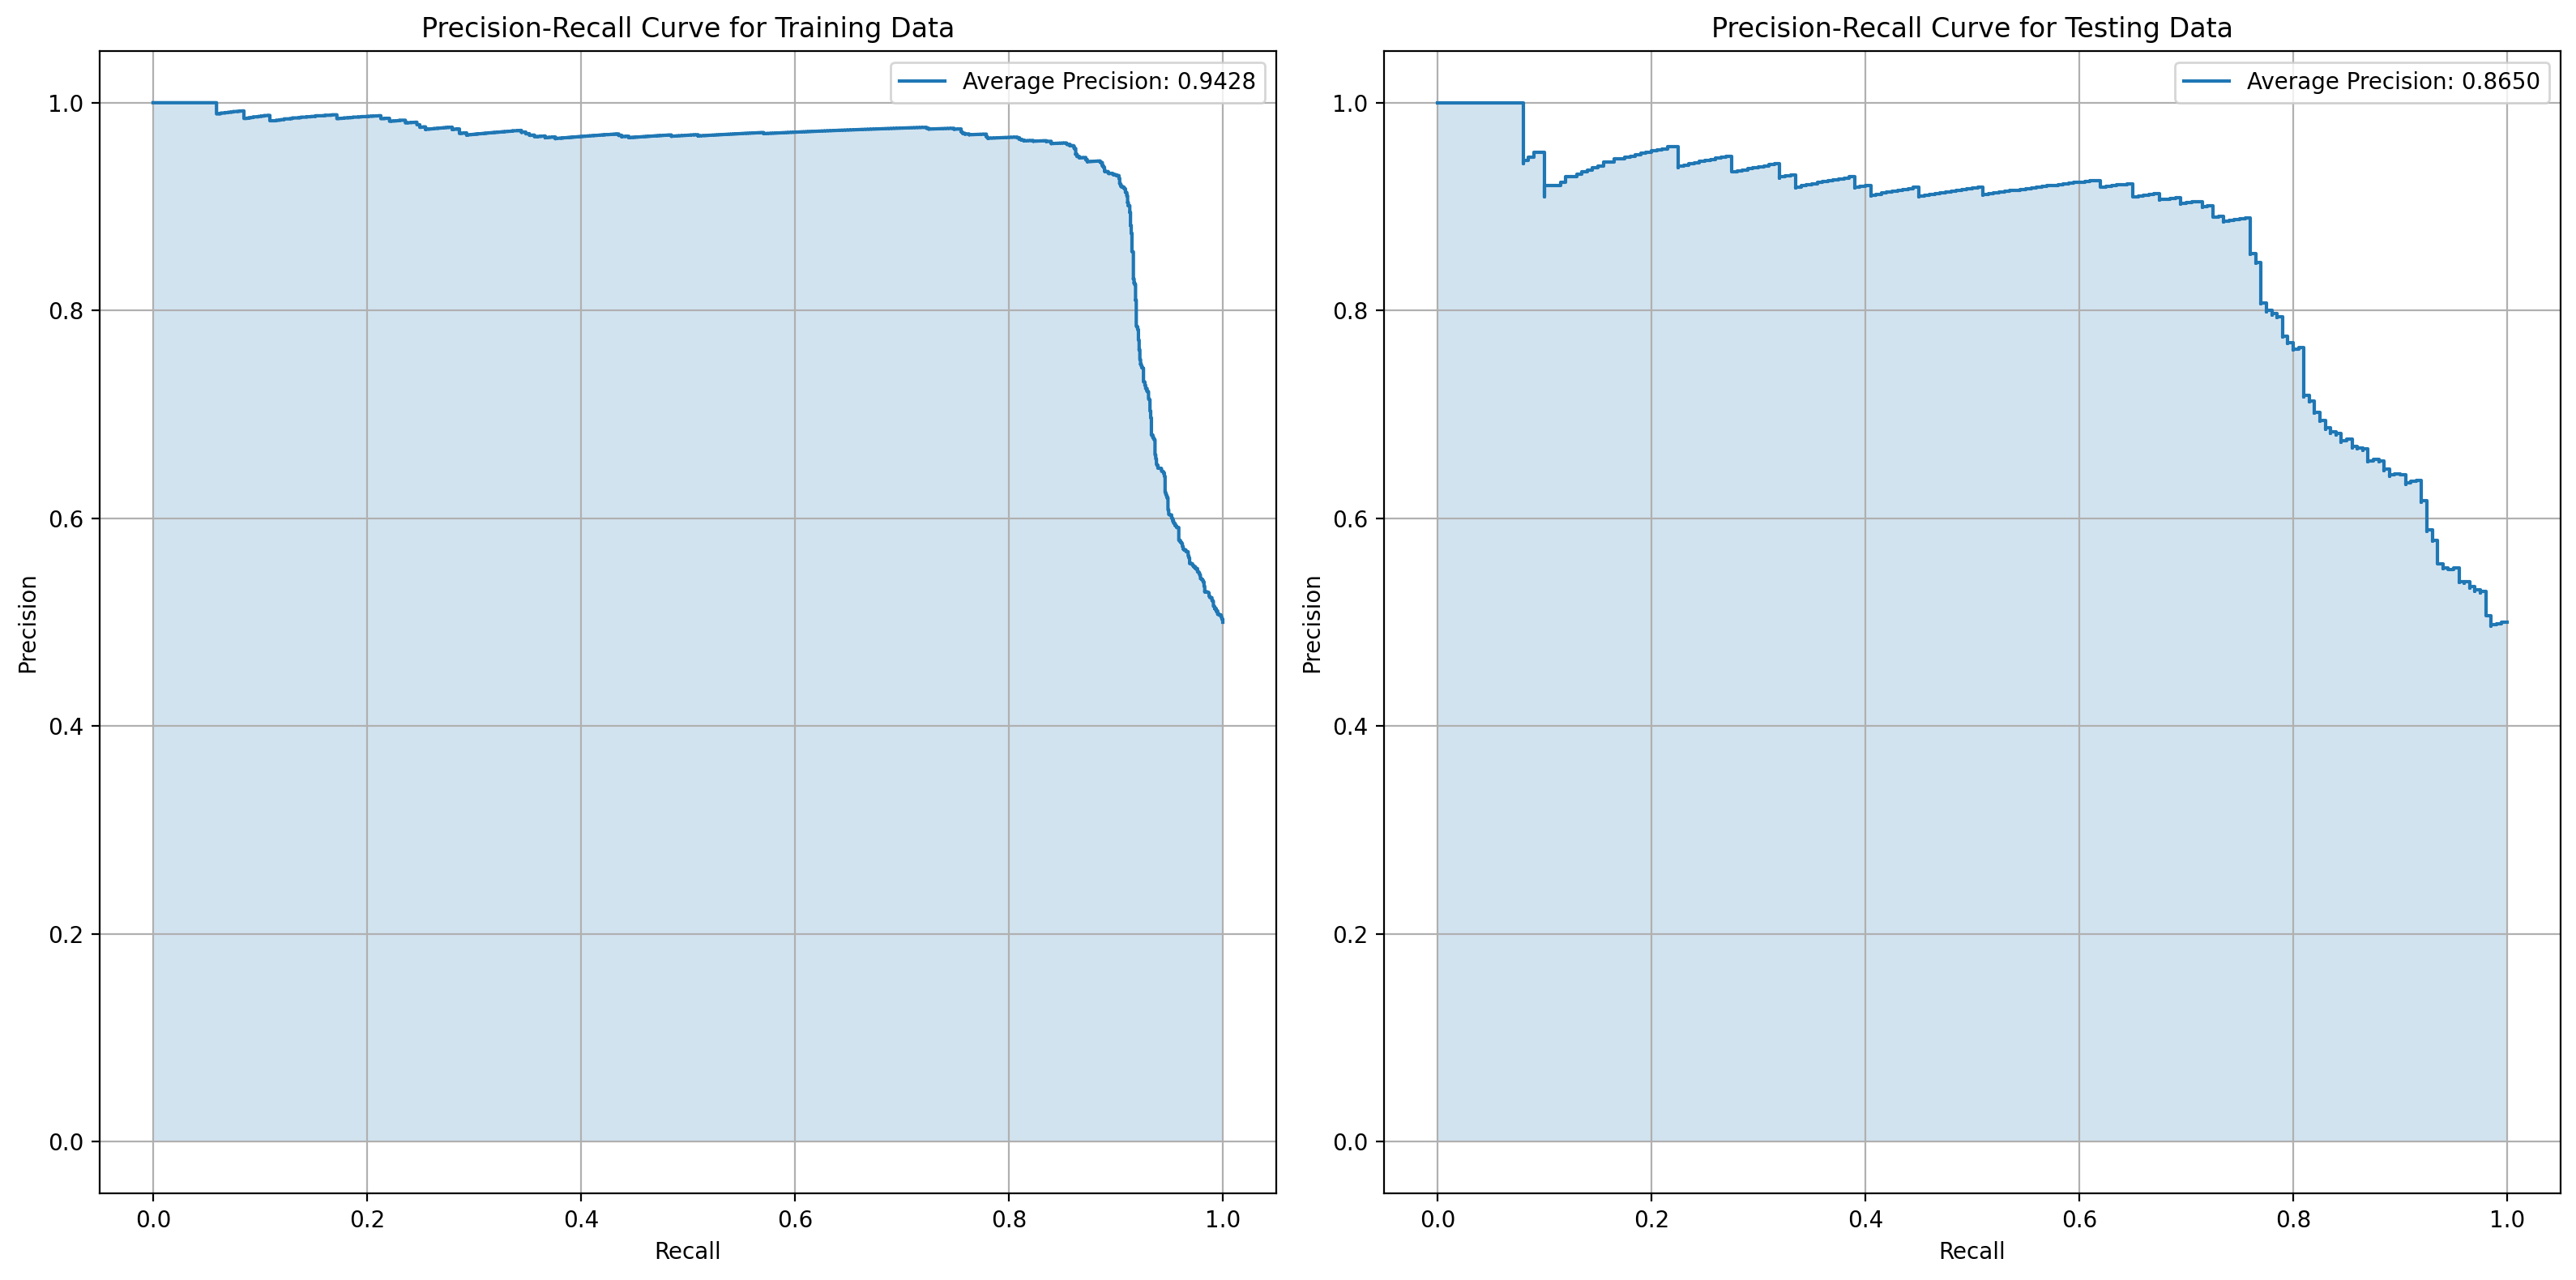

In [ ]:
# Calculate precision and recall for training data
precision_train, recall_train, _ = precision_recall_curve(train_labels_average, train_predictions_average)
average_precision_train = average_precision_score(train_labels_average, train_predictions_average)

# Calculate precision and recall for test data
precision_test, recall_test, _ = precision_recall_curve(test_labels_average, test_predictions_average)
average_precision_test = average_precision_score(test_labels_average, test_predictions_average)

# Plotting the PR curves in subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Training PR curve
axs[0].step(recall_train, precision_train, where="post", label=f"Average Precision: {average_precision_train:.4f}")
axs[0].fill_between(recall_train, precision_train, step="post", alpha=0.2)
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve for Training Data")
axs[0].legend(loc="best")
axs[0].grid(True)

# Testing PR curve
axs[1].step(recall_test, precision_test, where="post", label=f"Average Precision: {average_precision_test:.4f}")
axs[1].fill_between(recall_test, precision_test, step="post", alpha=0.2)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].set_title("Precision-Recall Curve for Testing Data")
axs[1].legend(loc="best")
axs[1].grid(True)

plt.tight_layout()
plt.show()

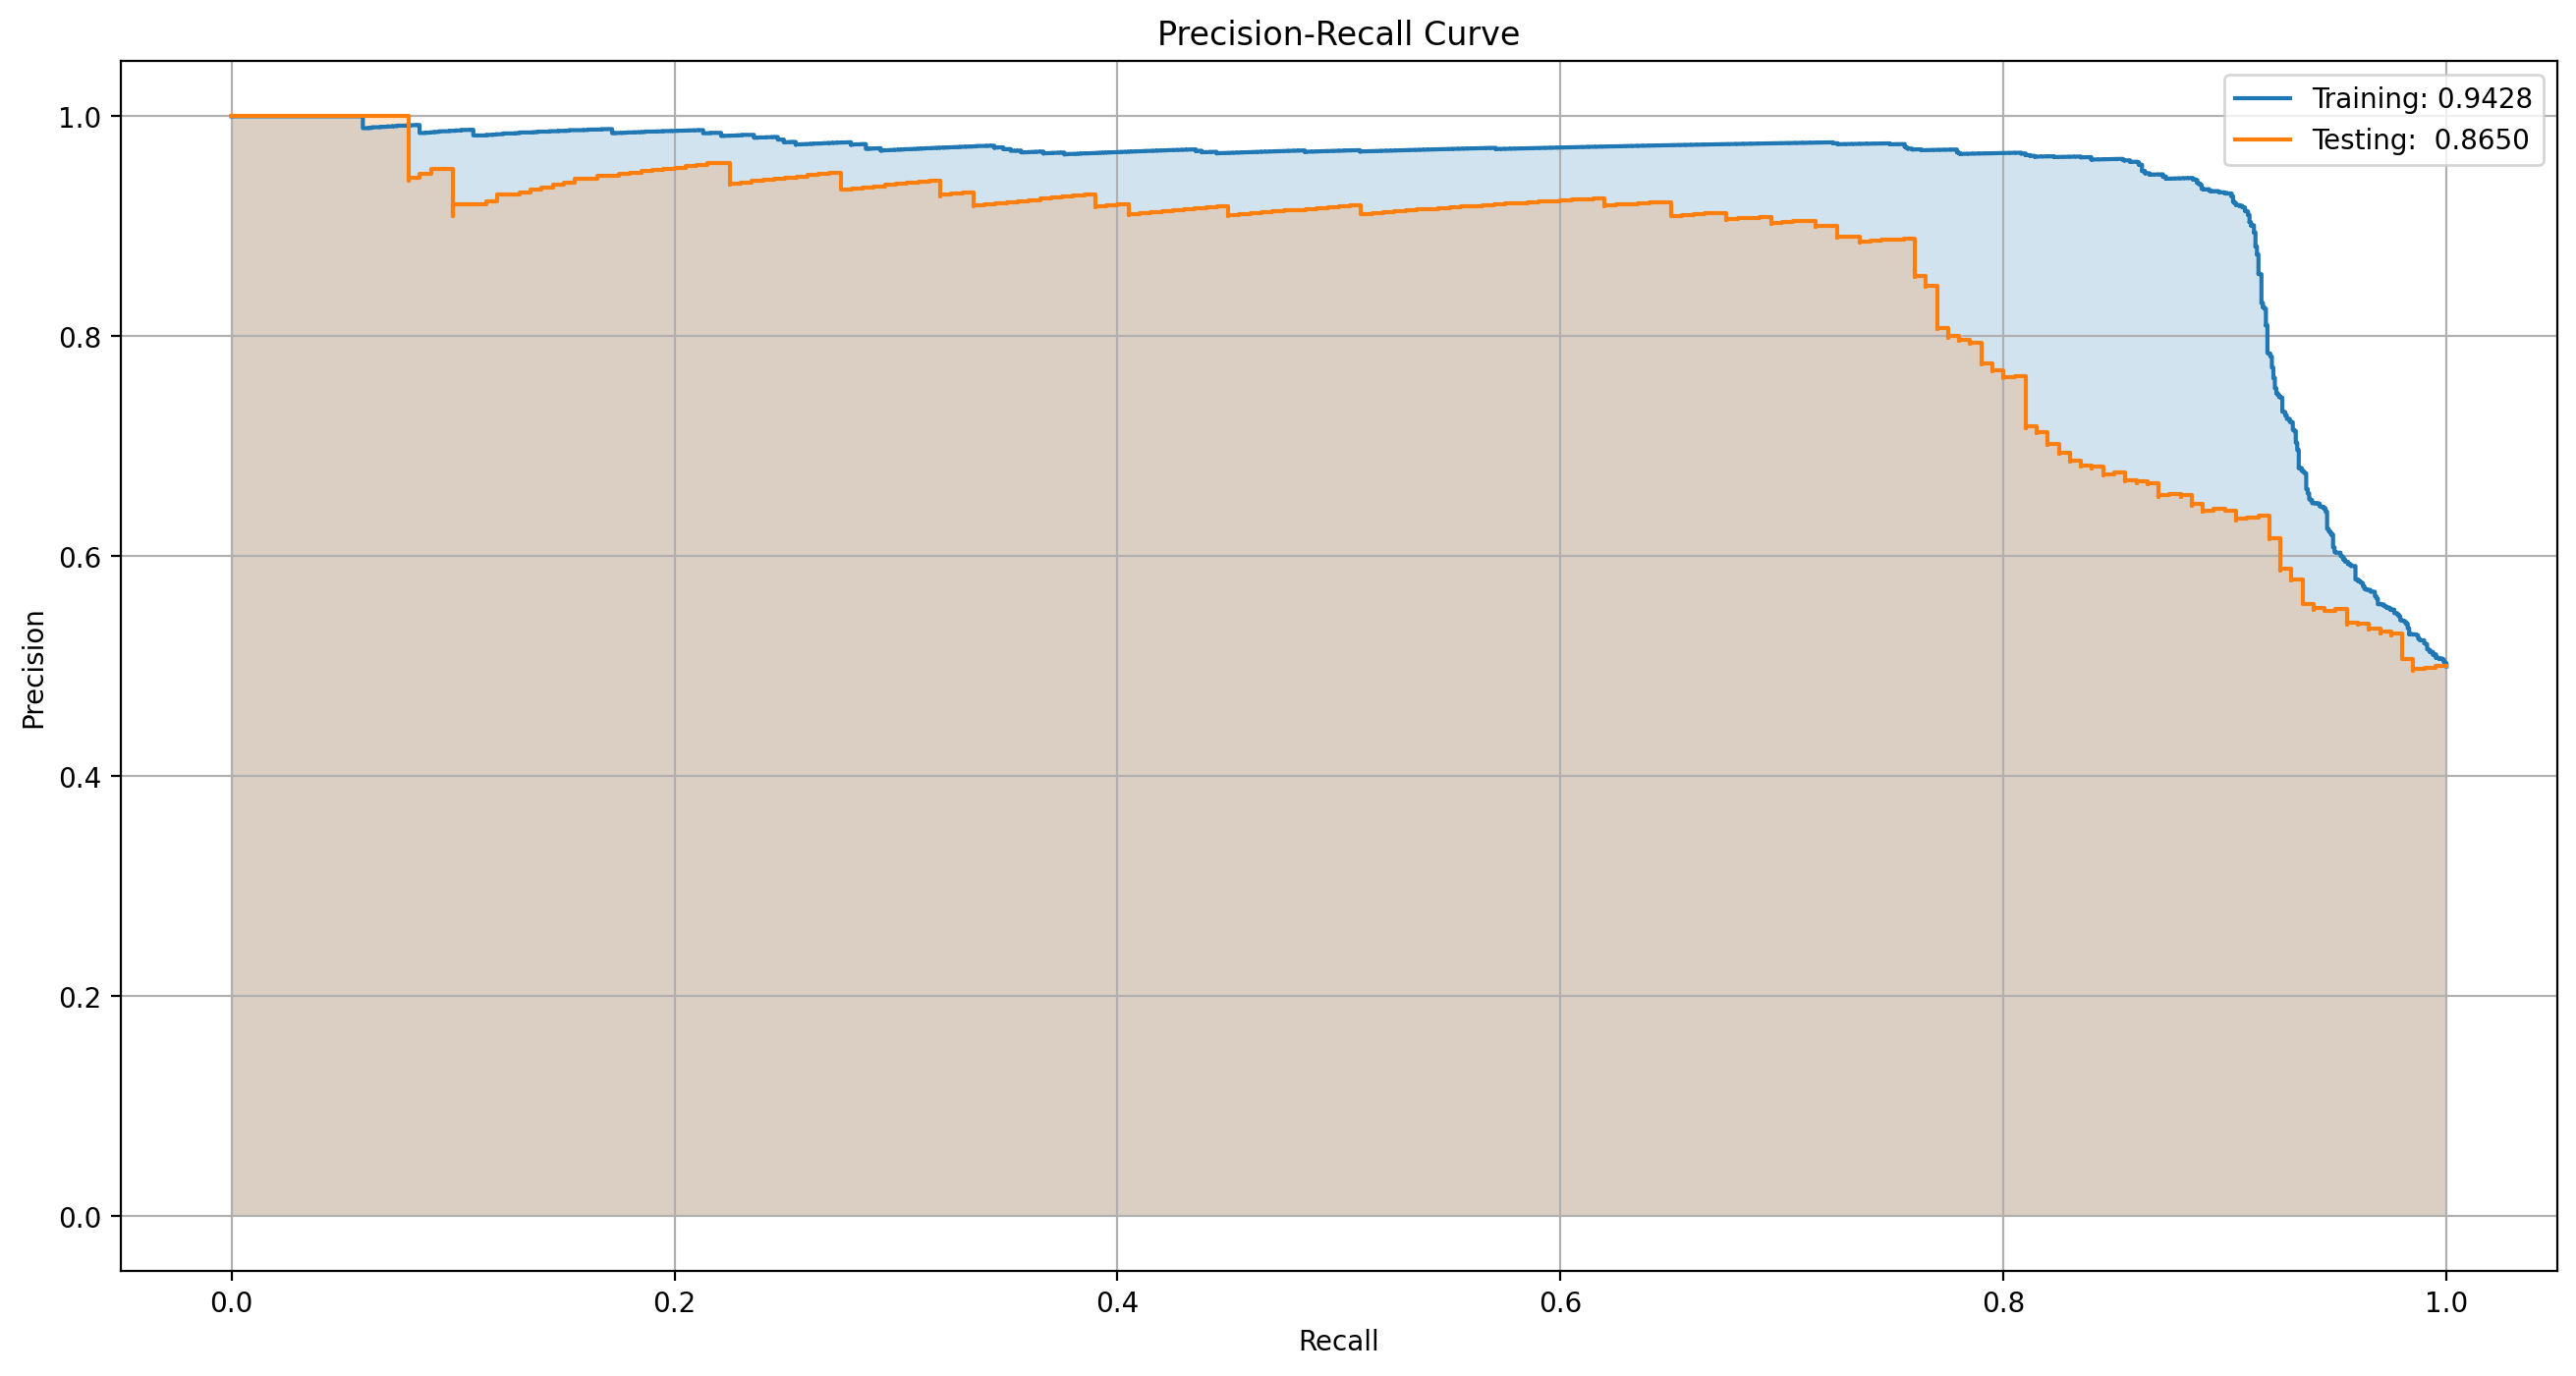

In [ ]:
# Calculate precision and recall for training data
precision_train, recall_train, _ = precision_recall_curve(train_labels_average, train_predictions_average)
average_precision_train = average_precision_score(train_labels_average, train_predictions_average)

# Calculate precision and recall for test data
precision_test, recall_test, _ = precision_recall_curve(test_labels_average, test_predictions_average)
average_precision_test = average_precision_score(test_labels_average, test_predictions_average)

# Plotting the PR curves
plt.figure(figsize=(16, 8))

# Training PR curve
plt.step(recall_train, precision_train, where="post", label=f"Training: {average_precision_train:.4f}")
plt.fill_between(recall_train, precision_train, step="post", alpha=0.2)

# Test PR curve
plt.step(recall_test, precision_test, where="post", label=f"Testing:  {average_precision_test:.4f}")
plt.fill_between(recall_test, precision_test, step="post", alpha=0.2)

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

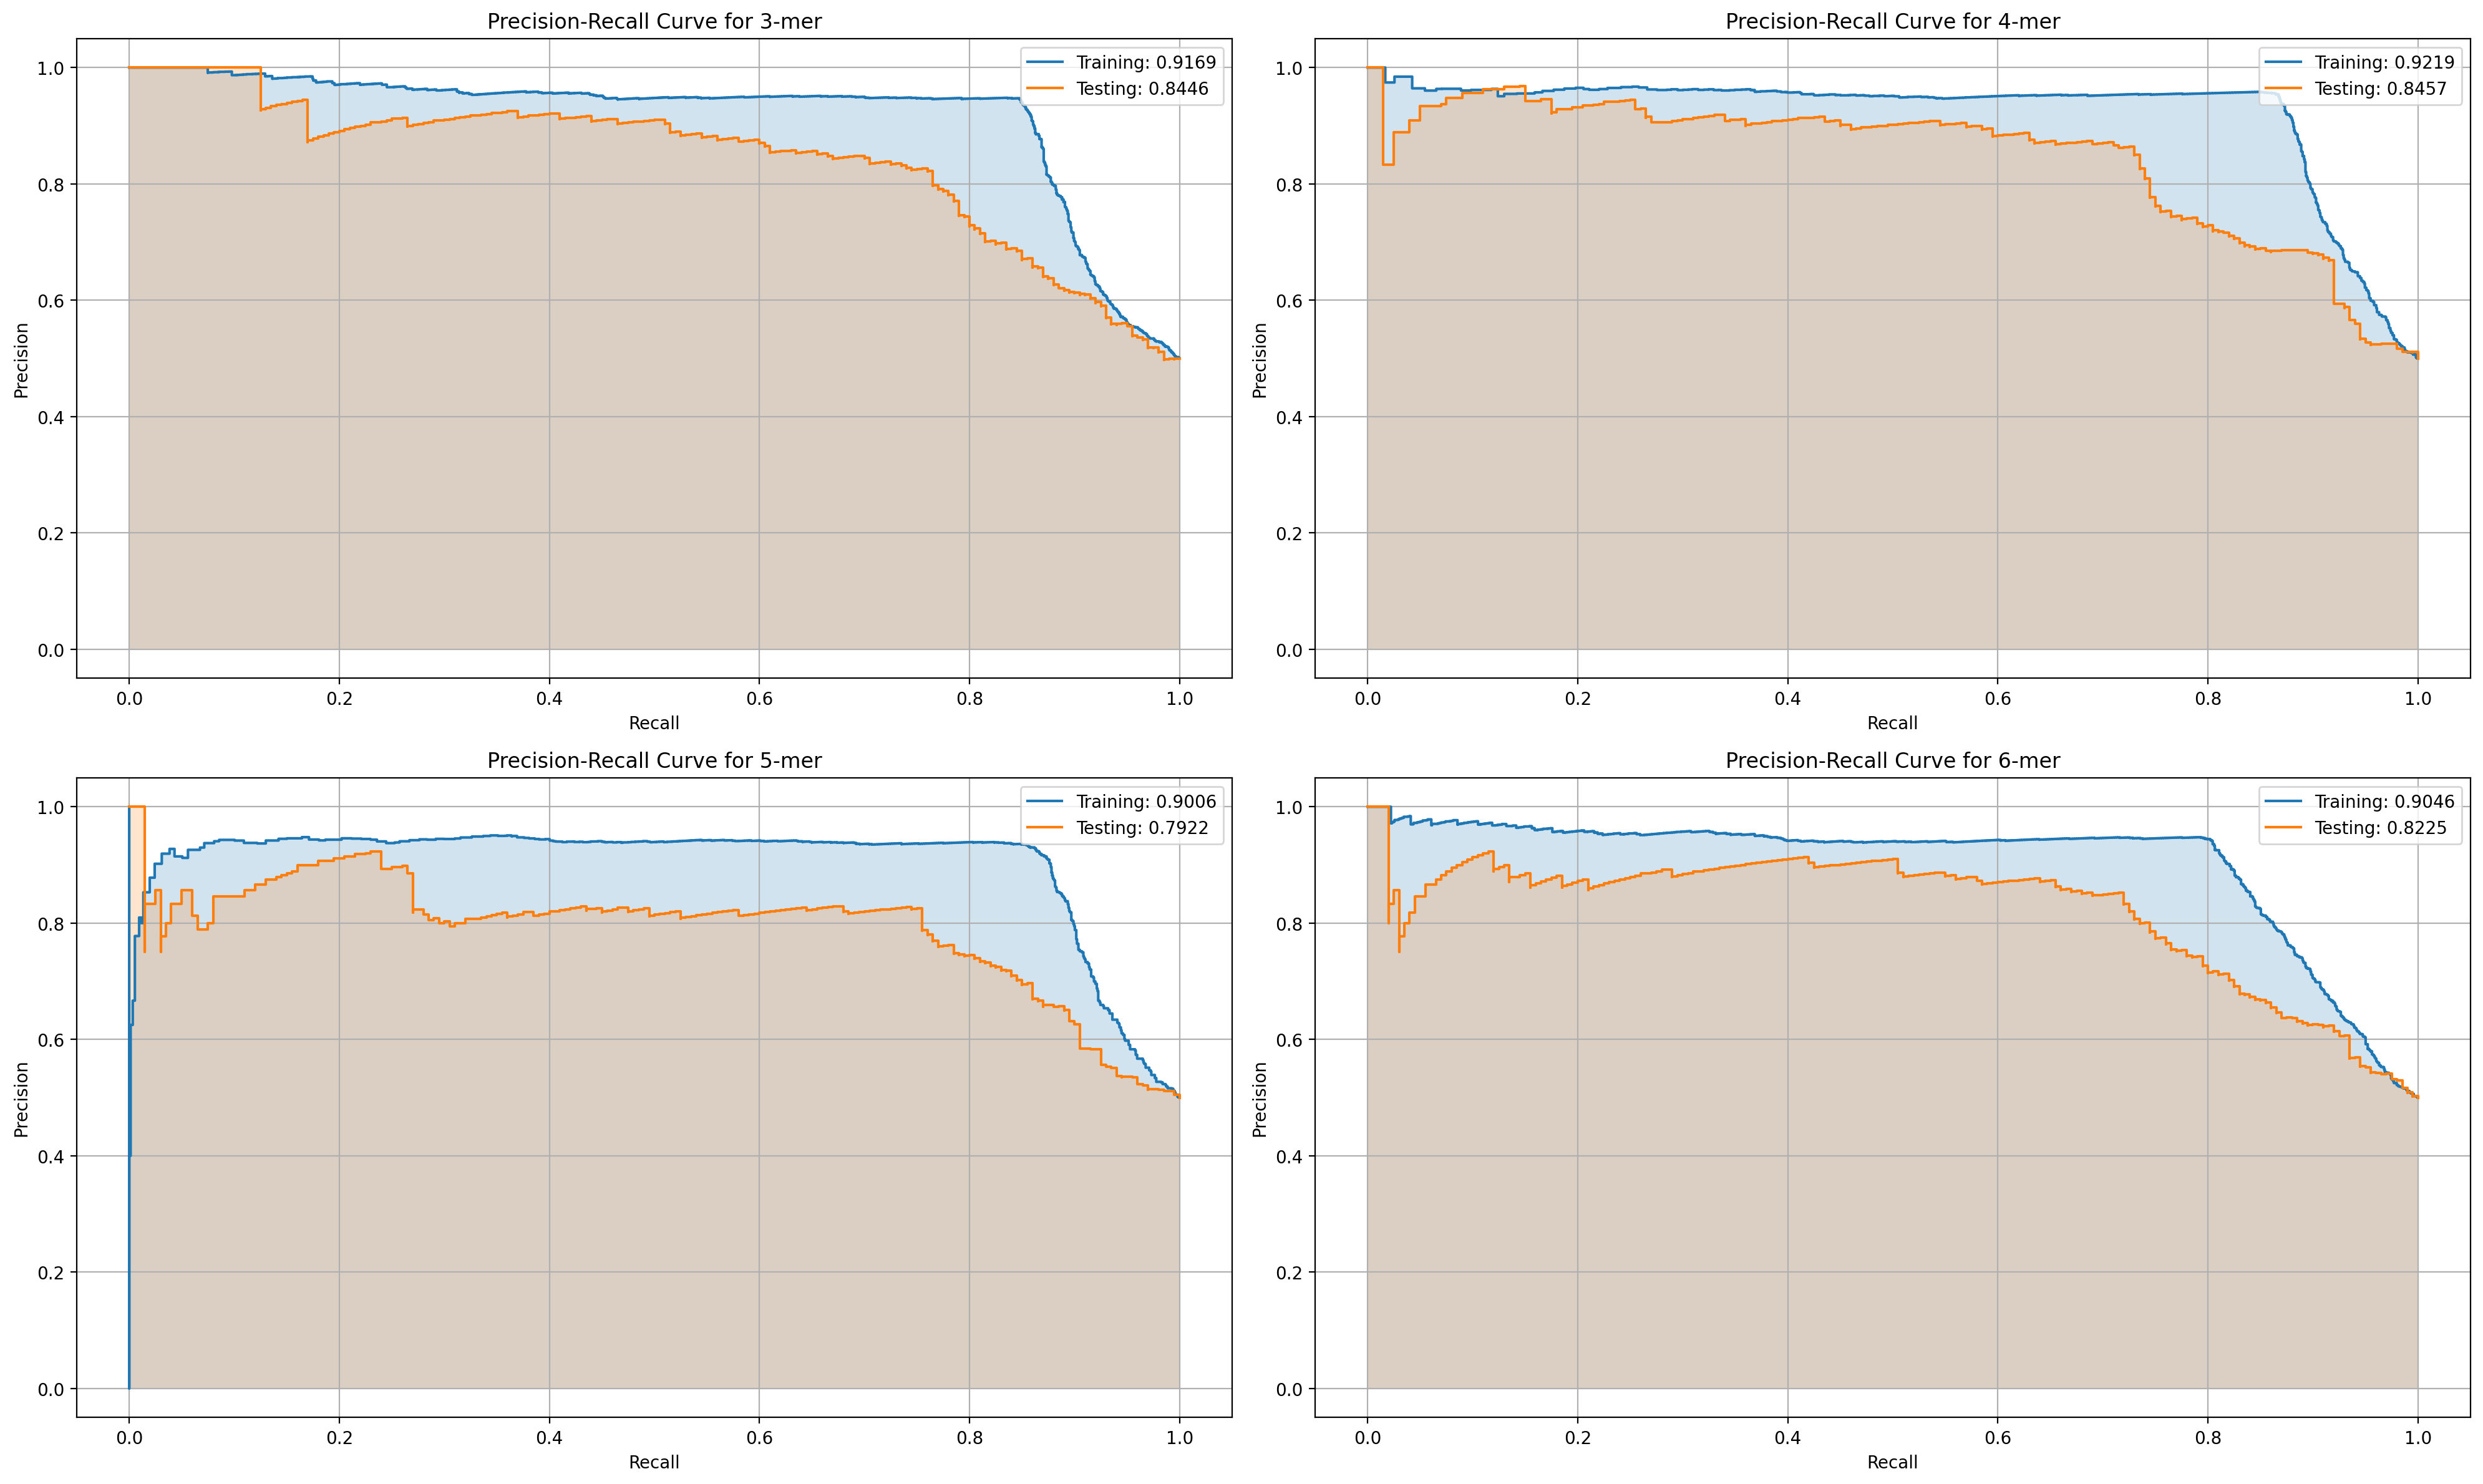

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Create a figure with 2 rows and 2 columns

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data for the current k-mer
    precision_train, recall_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_train = average_precision_score(train_labels_list[i], train_predictions_list[i])

    # Calculate precision and recall for test data for the current k-mer
    precision_test, recall_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_test = average_precision_score(test_labels_list[i], test_predictions_list[i])

    # Determine the position of the subplot
    ax = axs[i // 2, i % 2]

    # Training PR curve
    ax.step(recall_train, precision_train, where="post", label=f"Training: {average_precision_train:.4f}")
    ax.fill_between(recall_train, precision_train, step="post", alpha=0.2)
    ax.step(recall_test, precision_test, where="post", label=f"Testing: {average_precision_test:.4f}")
    ax.fill_between(recall_test, precision_test, step="post", alpha=0.2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve for {mer}-mer")
    ax.legend(loc="upper right")
    ax.grid(True)

plt.tight_layout()
plt.show()

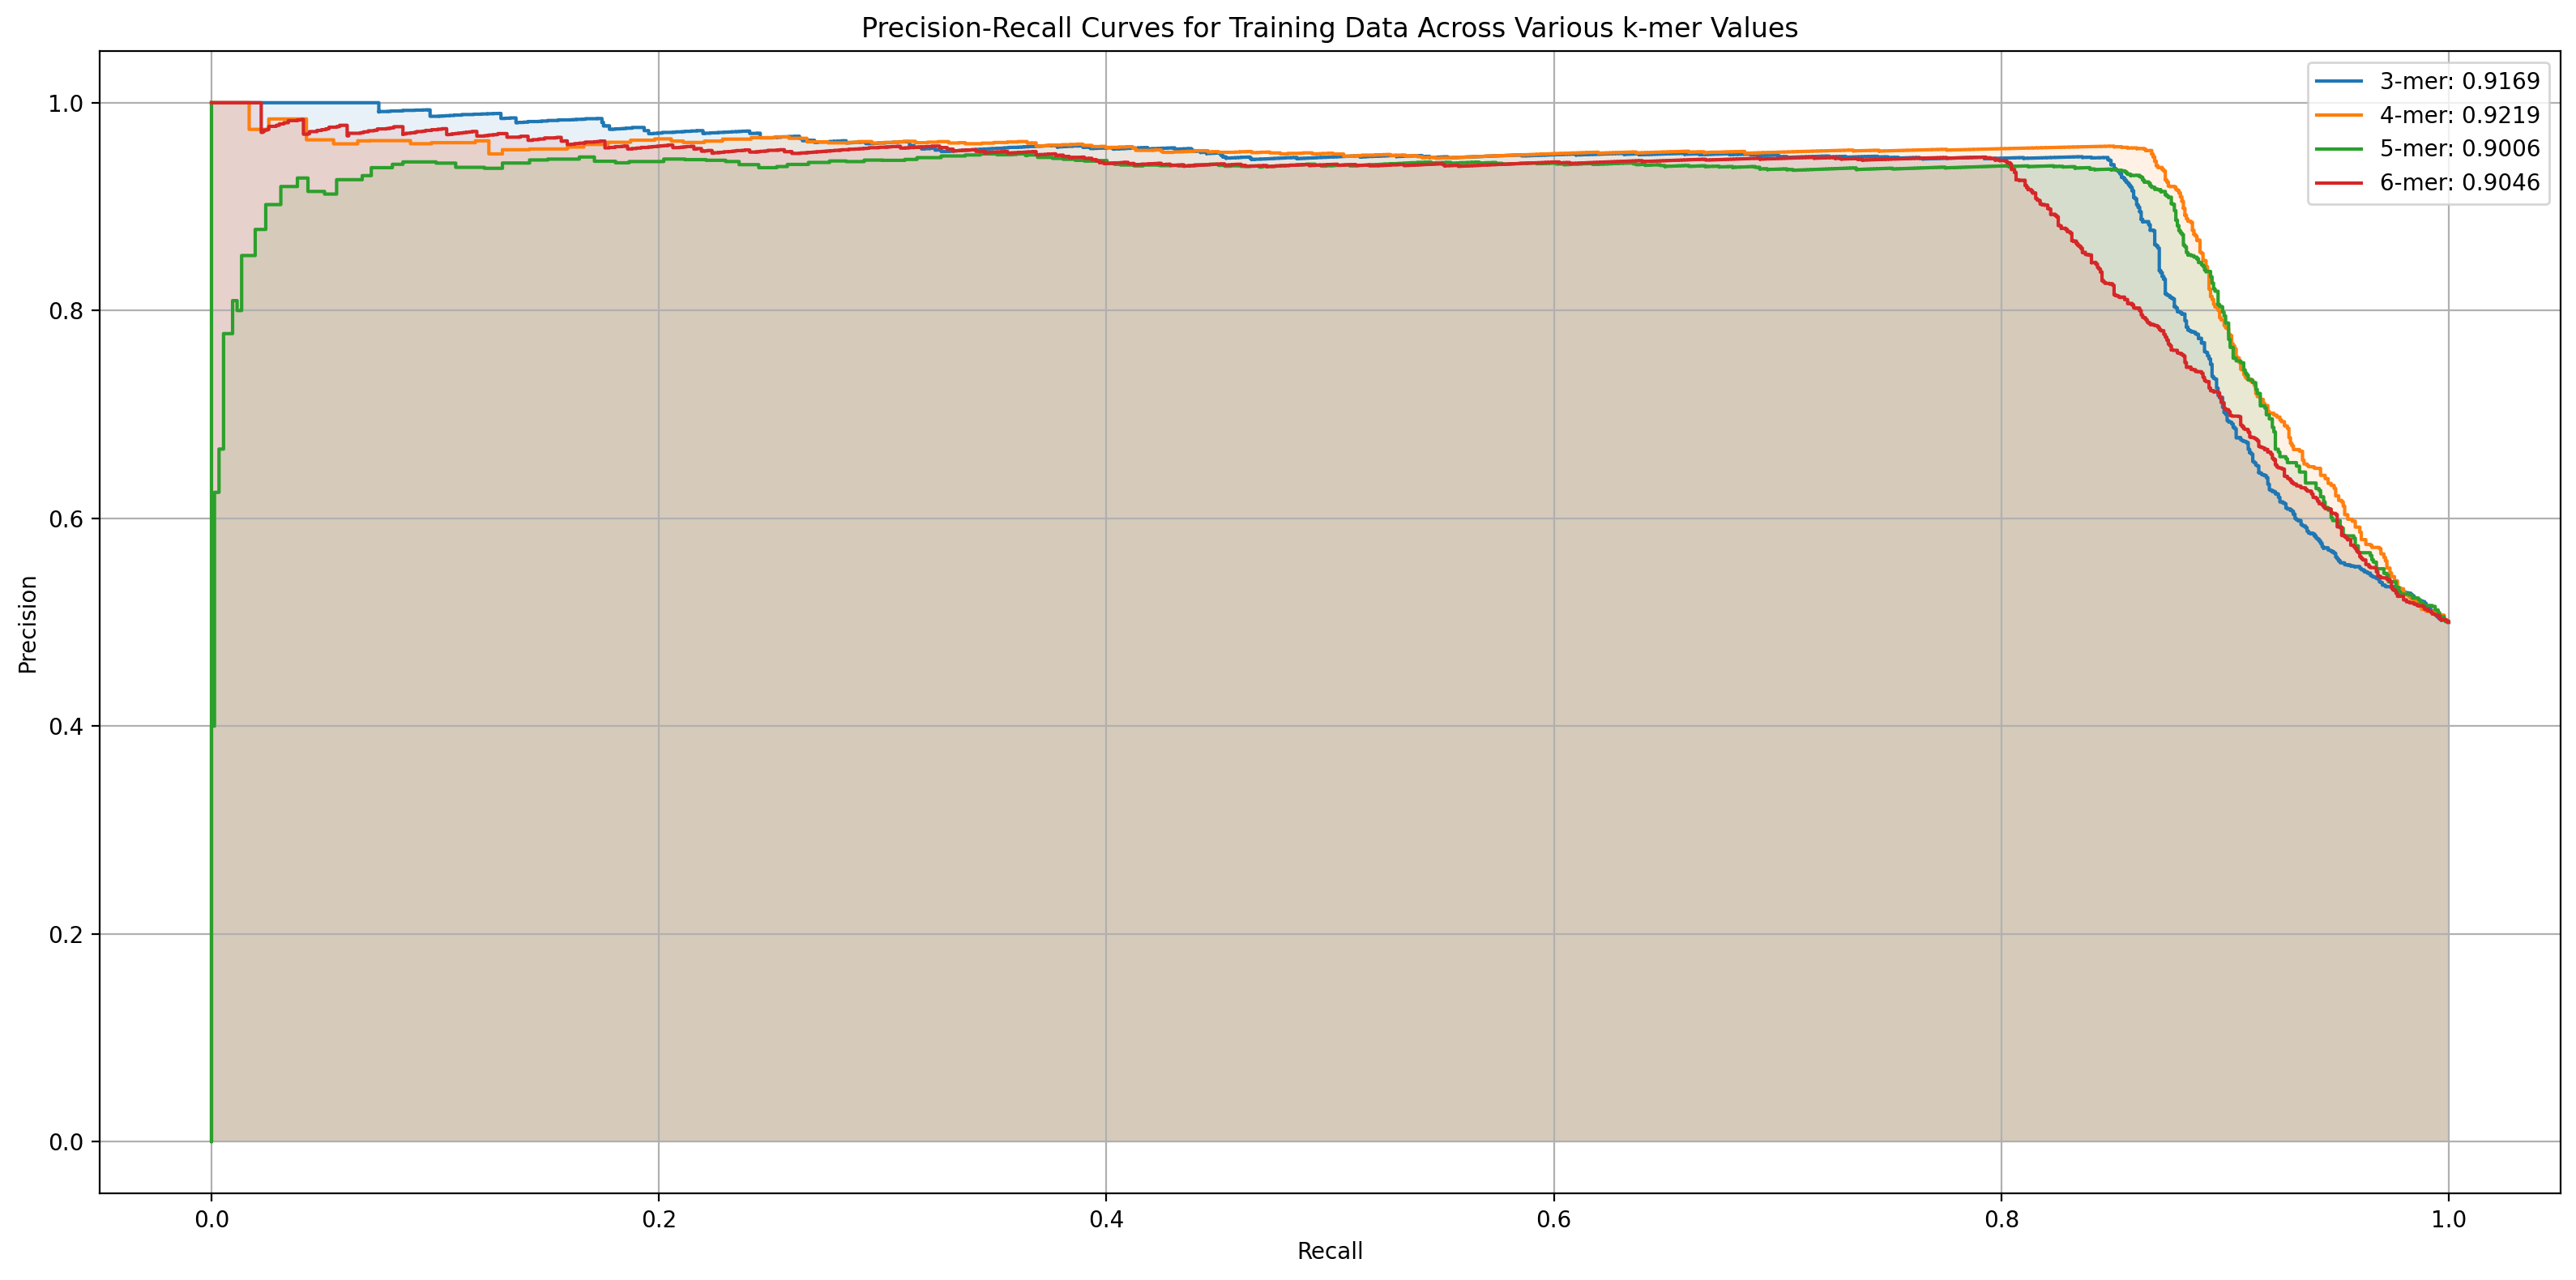

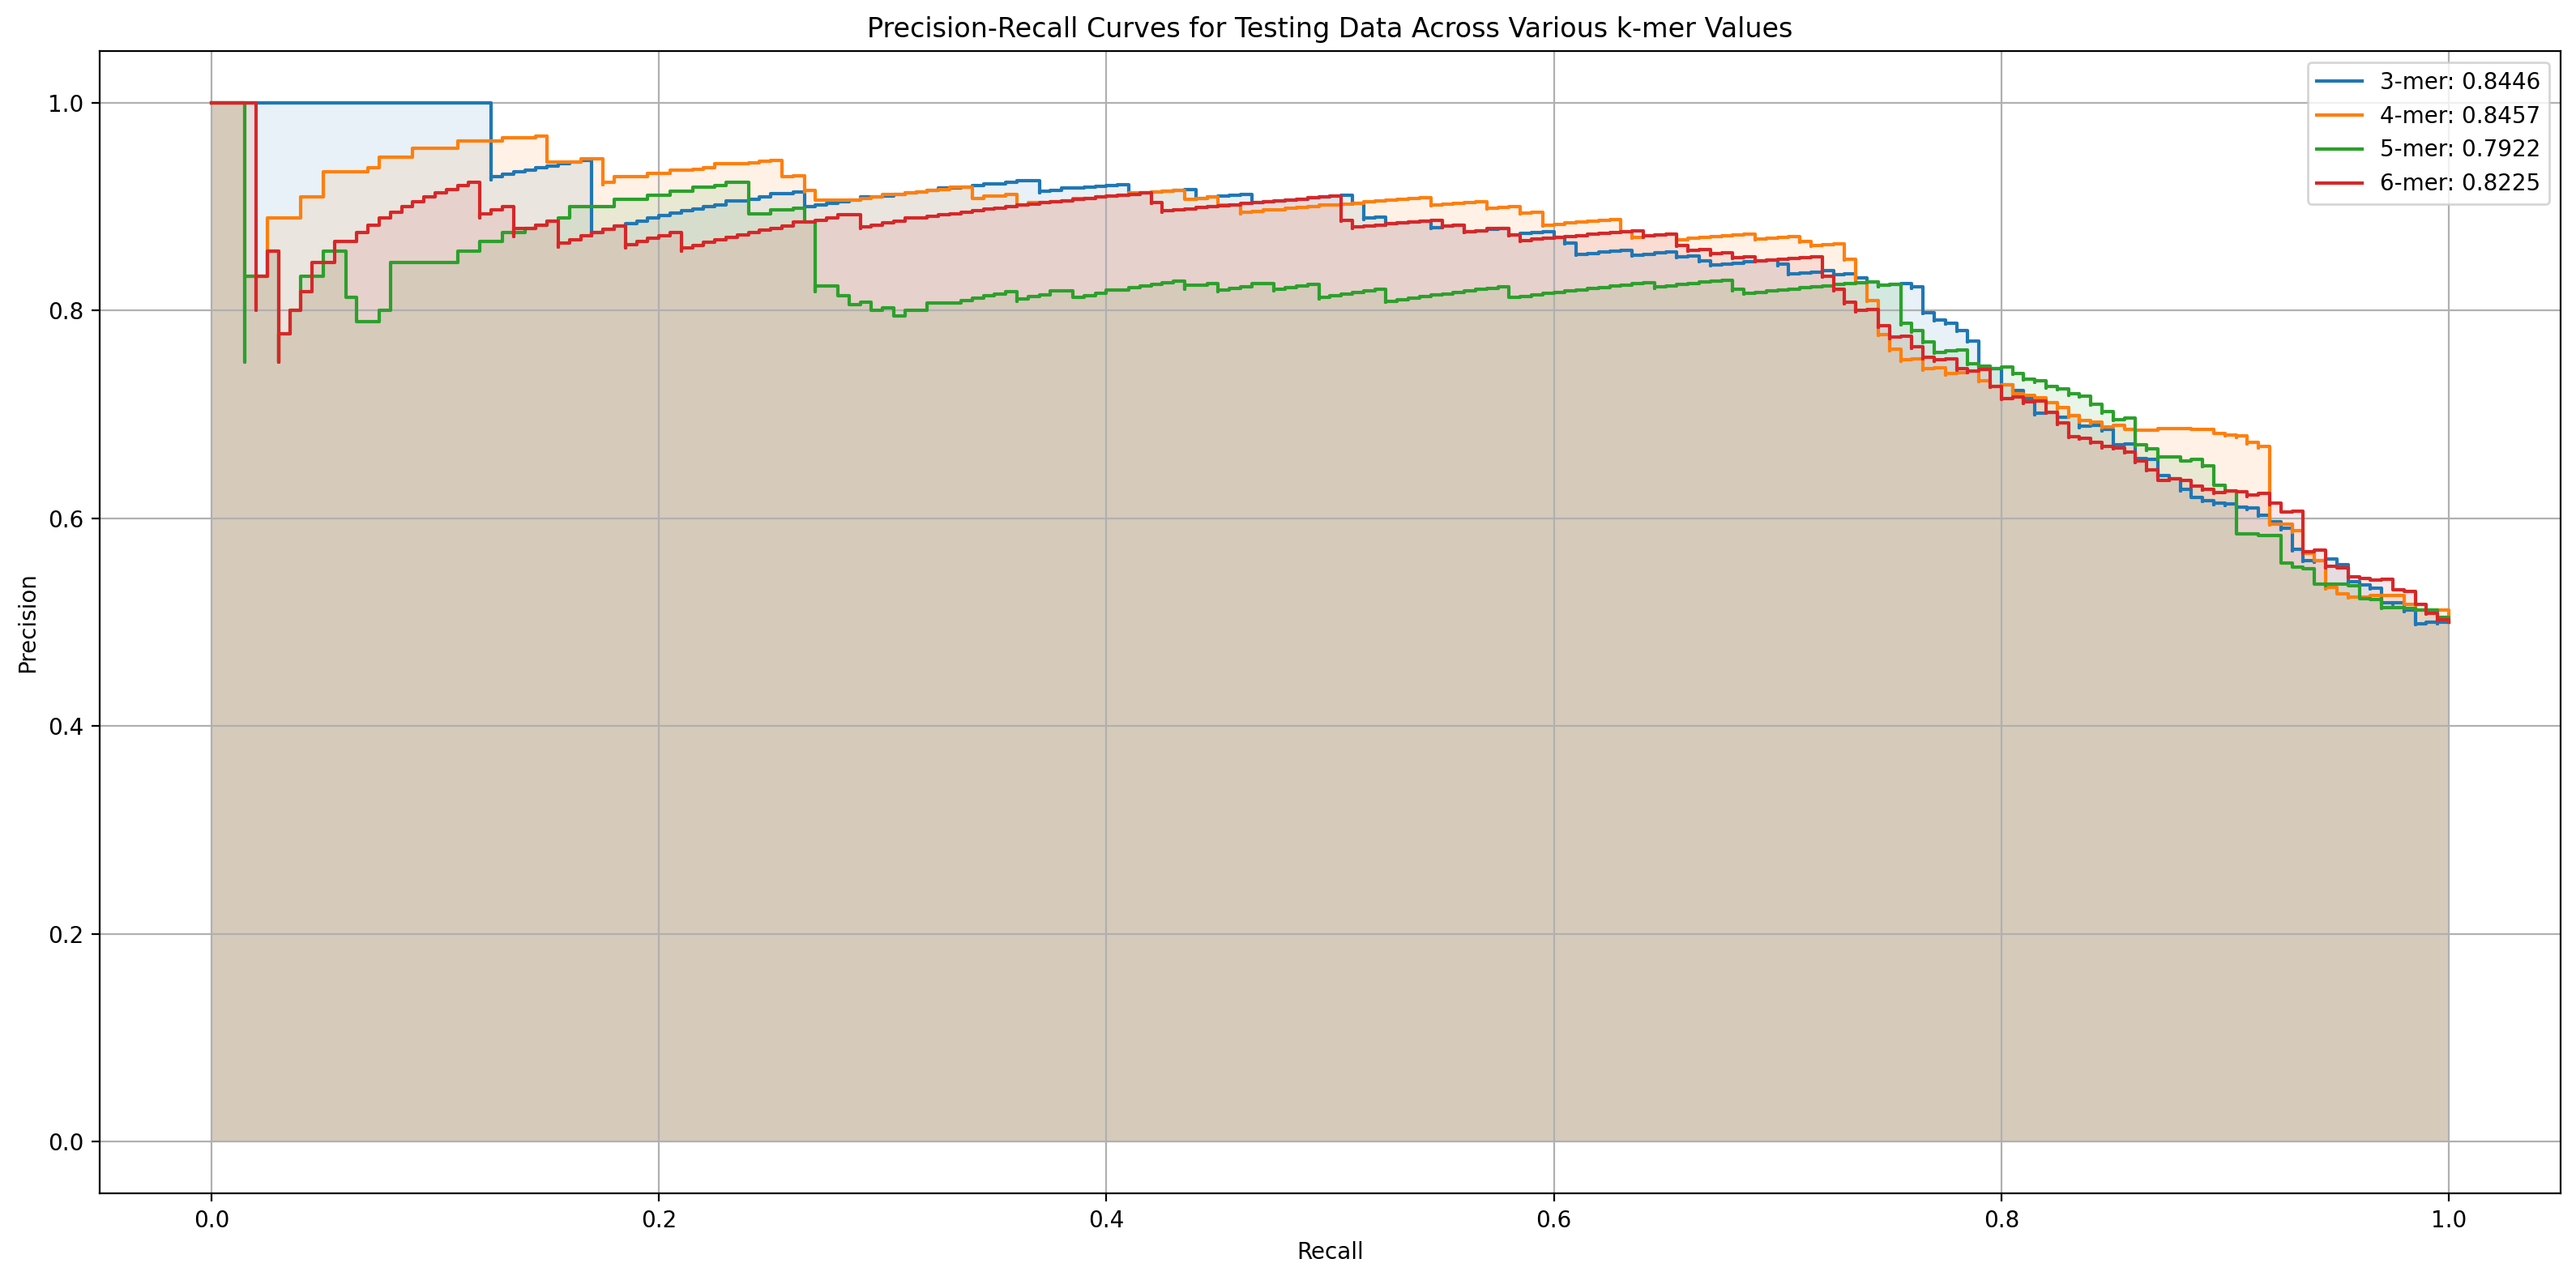

In [ ]:
# Plot for Training Data
plt.figure(figsize=(16, 8))

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data
    precision_train, recall_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_train = average_precision_score(train_labels_list[i], train_predictions_list[i])

    # Add the PR curve to the training plot
    plt.step(recall_train, precision_train, where="post", label=f"{mer}-mer: {average_precision_train:.4f}")
    plt.fill_between(recall_train, precision_train, step="post", alpha=0.1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Training Data Across Various k-mer Values")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Testing Data
plt.figure(figsize=(16, 8))
for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for test data
    precision_test, recall_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_test = average_precision_score(test_labels_list[i], test_predictions_list[i])

    # Add the PR curve to the testing plot
    plt.step(recall_test, precision_test, where="post", label=f"{mer}-mer: {average_precision_test:.4f}")
    plt.fill_between(recall_test, precision_test, step="post", alpha=0.1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Testing Data Across Various k-mer Values")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()